In [493]:
import pandas as pd
import numpy as np

import datetime as dt

import holidays
from calendra.asia import Qatar
from calendra.asia import HongKong

from pyorbital.moon_phase import moon_phase

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox

import matplotlib.pyplot as plt
%matplotlib inline

In [213]:
calls_import = pd.read_csv('../data/Calls_Table_data.csv', delimiter='\t', encoding='utf-16')

In [214]:
calls_full_df = calls_import

In [480]:
calls_full_df.drop_duplicates(inplace=True)

In [217]:
calls_full_df.reset_index(inplace=True)

In [218]:
calls_full_df.columns

Index(['index', 'BEAT', 'CALL_CODE', 'CALL_DESC', 'CALL GROUP', 'YEAR',
       'MAP COLOR', 'CALL VOLUME', 'Current Year Mark', 'Select View',
       'Boundary Selection', 'CALL DESCRIPTION', 'CALL CODE', 'Map Selection',
       'DAY_ONLY', 'EVENT', 'Geometry (MCPP MAP.shp)', 'Geometry',
       'Geometry (BEAT MAP.shp)', 'HOW_RECVD', 'NEIGHBORHOOD',
       'Number of Records', 'ORIG_TIME_QUEUED', 'PCT', 'PCT Full', 'PRECINCT',
       'Beat', 'first prec (BEAT MAP.shp)', 'Neighborho',
       'precinct (MCPP MAP.shp)', 'Precinct', 'sector (BEAT MAP.shp)',
       'st area sh (MCPP MAP.shp)', 'St Area Sh', 'st area sh (BEAT MAP.shp)',
       'st length  (MCPP MAP.shp)', 'St Length', 'st length  (BEAT MAP.shp)'],
      dtype='object')

In [219]:
calls_full_df['dt_time'] = pd.to_datetime(calls_full_df['ORIG_TIME_QUEUED'])

In [220]:
calls_full_df['date'] = calls_full_df['dt_time'].dt.date

In [221]:
calls_full_df['year'] = calls_full_df['dt_time'].dt.year

In [222]:
calls_full_df['month'] = calls_full_df['dt_time'].dt.month

In [223]:
calls_full_df['day'] = calls_full_df['dt_time'].dt.day

In [224]:
calls_full_df['day_of_week'] = calls_full_df['dt_time'].dt.weekday

In [225]:
calls_full_df['month_day'] = calls_full_df['dt_time'].dt.strftime('%m/%d')
    

In [15]:
class CustomHolidays(holidays.US):
    def _populate(self, year):
        # Populate the holiday list with the default US holidays
        holidays.US._populate(self, year)
        # Example: Add Ninja Turtle Day
        #self[dt.date(year, 7, 13)] = "Ninja Turtle Day"
        for year in range(2009, 2030):
            # Add Valentine's day
            self[dt.date(year, 2, 14)] = "Valentines Day"
            # Add St Patricks Day
            self[dt.date(year, 3, 17)] = "St Patricks Day"
            # Add Easter
            self[holidays.easter(year=year)] = "Easter"
            # Add Good Friday
            self[holidays.easter(year=year)  -  dt.timedelta(days=2)] = "Good Friday"
            # Add Christmas Eve
            self[dt.date(year, 12, 24)] = "Christmas Eve"
            # Add New Years Eve
            self[dt.date(year, 12, 31)] = "New Years Eve"
            # Add Chinese New Year
            chinese = HongKong()
            for date, label in chinese.get_chinese_new_year(year):
                self[date] = label

In [61]:
qatar_holidays = Qatar()
class IslamicHolidays(holidays.HolidayBase):
    def _populate(self, year):
        # Populate the holiday list with blank base holidays
        holidays.HolidayBase._populate(self, year)
        for year in range(2009, 2030):
            days = qatar_holidays.get_calendar_holidays(year)
            # Add Ramadan
            for i in range(1, len(days)):
                if qatar_holidays.get_calendar_holidays(year)[i][1] == 'Start of ramadan':
                    for day in range(30):
                        self[qatar_holidays.get_calendar_holidays(year)[i][0] + dt.timedelta(days=day-1)] = "Ramadan"
                else:
                    self[qatar_holidays.get_calendar_holidays(2018)[1][0] - dt.timedelta(days=2)] = qatar_holidays.get_calendar_holidays(year)[i][1]
                       

In [17]:
hebcal_2010 = pd.read_csv('../data/hebcal_2010_usa.csv')
hebcal_2015 = pd.read_csv('../data/hebcal_2015_usa.csv')
hebcal_2020 = pd.read_csv('../data/hebcal_2020_usa.csv')
hebcal_2025 = pd.read_csv('../data/hebcal_2025_usa.csv')

hebcal = pd.concat([hebcal_2010, hebcal_2015, hebcal_2020, hebcal_2025])
hebcal.reset_index(inplace=True)
hebcal['date'] = pd.to_datetime(hebcal["Start Date"]).dt.date

In [18]:
class JewishHolidays(holidays.HolidayBase):
    def _populate(self, year):
        # Populate the holiday list with blank base holidays
        holidays.HolidayBase._populate(self, year)
        for year in range(2009, 2030):
            for i in range(len(hebcal)):
                self[hebcal['date'][i]] = hebcal['Subject'][i]           

In [115]:
custom_holidays = []
for date, name in sorted(CustomHolidays(years=2016).items()):
    custom_holidays.append([date, name])

custom_holidays = pd.DataFrame(custom_holidays, columns=['date', 'holiday'])

In [456]:
calls_full_df = calls_full_df.join(custom_holidays.set_index('date'), on='date')

In [124]:
islamic_holidays = []
for date, name in sorted(IslamicHolidays(years=2016).items()):
    islamic_holidays.append([date, name])

islamic_holidays = pd.DataFrame(islamic_holidays, columns=['date', 'islamic_holiday'])

/anaconda3/lib/python3.6/site-packages/calendra/core.py:760: UserWarning: Please take note that, due to arbitrary decisions, this Islamic calendar computation may be wrong.
  warnings.warn('Please take note that, due to arbitrary decisions, '


In [226]:
calls_full_df = calls_full_df.join(islamic_holidays.set_index('date'), on='date')

In [126]:
jewish_holidays = []
for date, name in sorted(JewishHolidays(years=2016).items()):
    jewish_holidays.append([date, name])

jewish_holidays = pd.DataFrame(jewish_holidays, columns=['date', 'jewish_holiday'])

In [227]:
calls_full_df = calls_full_df.join(jewish_holidays.set_index('date'), on='date')

In [19]:
events = ({
    'Pride Parade' : ['6/30/2019', '6/24/2018', '6/25/2017', '6/26/2016', '6/28/2015',
                      '6/29/2014', '6/30/2013', '6/24/2012', '6/26/2011', '6/27/2010'],
    'Seafair' : ['8/2/2019', '8/3/2019', '8/4/2019', '8/3/2018', '8/4/2018', '8/5/2018',
                '8/4/2017', '8/5/2017', '8/6/2017', '8/5/2016', '8/6/2016', '8/7/2016',
                '7/31/2015', '8/1/2015', '8/2/2015', '8/1/2014', '8/2/2014', '8/3/2014',
                '8/2/2013', '8/3/2013', '8/4/2013', '8/3/2012', '8/4/2012', '8/5/2012',
                '8/5/2011', '8/6/2011', '8/7/2011', '8/6/2010', '8/7/2010', '8/8/2010' ],
    'Soltice Parade': ['6/30/2019', '6/16/2018', '6/17/2017', '6/18/2016', '6/20/2015',
                      '6/21/2014', '6/22/2013', '6/16/2012', '6/18/2011', '6/19/2010'],
    'Womens March' : ['1/19/2019', '1/20/2018', '1/21/2017'],
})

In [254]:
seattle_events = []
for event in events.keys():
    for day in events[event]:
        seattle_events.append([dt.datetime.strptime(day, '%m/%d/%Y'), event])
seattle_events = pd.DataFrame(seattle_events, columns=['date','local_event'])
seattle_events['date'] = seattle_events['date'].dt.date

In [257]:
calls_full_df = calls_full_df.join(seattle_events.set_index('date'), on='date')

In [229]:
calls_full_df['full_moon'] = moon_phase(calls_full_df['date'].values)>.99
calls_full_df['new_moon'] = moon_phase(calls_full_df['date'].values)<.01

In [230]:
weather_import = pd.read_csv('../data/historical_weather.csv')
weather_import['date'] = pd.to_datetime(weather_import['DATE']).dt.date

In [231]:
weather_hist = (weather_import[['date', 'TMIN', 'TMAX', 'PRCP', 'SNOW']]
                .rename(columns={'PRCP':'precip', 'TMIN':'temp_min', 'TMAX':'temp_max',
                                 'PRCP':'precip', 'SNOW':'snow'}))

In [232]:
weather_hist['precip^2'] = weather_hist['precip']**2
weather_hist['snow^2'] = weather_hist['snow']**2

In [233]:
calls_full_df = calls_full_df.join(weather_hist.set_index('date'), on='date')

In [258]:
calls_full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96208 entries, 0 to 96207
Data columns (total 56 columns):
index                        96208 non-null int64
BEAT                         96208 non-null object
CALL_CODE                    96208 non-null object
CALL_DESC                    96208 non-null object
CALL GROUP                   96208 non-null object
YEAR                         96208 non-null int64
MAP COLOR                    96036 non-null object
CALL VOLUME                  96208 non-null int64
Current Year Mark            96208 non-null object
Select View                  96208 non-null object
Boundary Selection           96208 non-null object
CALL DESCRIPTION             96208 non-null object
CALL CODE                    96208 non-null object
Map Selection                96036 non-null object
DAY_ONLY                     96208 non-null object
EVENT                        96208 non-null int64
Geometry (MCPP MAP.shp)      96036 non-null object
Geometry                    

In [315]:
seahawks_schedule = pd.read_csv('../data/seahawks_schedule.csv')
huskies_schedule = pd.read_csv('../data/huskies_schedule.csv')
sounders_schedule = pd.read_csv('../data/sounders_schedule.csv')

In [317]:
seahawks_schedule.columns

Index(['Unnamed: 0', 'year', 'Week', 'Day', 'Date', 'Unnamed: 5', 'Unnamed: 6',
       'Unnamed: 7', 'OT', 'Rec', 'Unnamed: 10', 'Opp'],
      dtype='object')

In [370]:
seahawks_schedule = seahawks_schedule[seahawks_schedule['Opp'].notna()]
seahawks_schedule.reset_index(drop=True)
seahawks_schedule = seahawks_schedule[seahawks_schedule['Opp'] != 'Bye Week']
seahawks_schedule = seahawks_schedule.reset_index(drop=True)

In [376]:
seahawks_schedule['date'] = ''

for i in range(len(seahawks_schedule)):
    seahawks_schedule['date'][i] = (f"{seahawks_schedule.iloc[i]['Date']}, {seahawks_schedule.iloc[i]['year']}")

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [382]:
seahawks_schedule['date'] = pd.to_datetime(seahawks_schedule['date']).dt.date

In [388]:
seahawks_schedule['Week'].unique()

array(['1', '2', '3', '4', '6', '7', '8', '9', '10', '11', '12', '13',
       '14', '15', '16', '17', 'Wild Card', 'Division', '5',
       'Conf. Champ.', 'SuperBowl'], dtype=object)

In [419]:
seahawks_schedule['seahawks_game'] = ''
for i in range(len(seahawks_schedule)):
    if type(seahawks_schedule.iloc[i]['Unnamed: 10']) == str:
        if seahawks_schedule.iloc[i]['Week'] == 'SuperBowl':
            seahawks_schedule['seahawks_game'][i] = 'SuperBowl'
        elif seahawks_schedule.iloc[i]['Week'] in ['Wild Card', 'Division','Conf. Champ.']:
            seahawks_schedule['seahawks_game'][i] = 'away_Playoffs'
        else:
            seahawks_schedule['seahawks_game'][i] = 'away_Regular'
    else:     
        if seahawks_schedule.iloc[i]['Week'] == 'SuperBowl':
            seahawks_schedule['seahawks_game'][i] = 'SuperBowl'
        elif seahawks_schedule.iloc[i]['Week'] in ['Wild Card', 'Division','Conf. Champ.']:
            seahawks_schedule['seahawks_game'][i] = 'home_Playoffs'
        else:
            seahawks_schedule['seahawks_game'][i] = 'home_Regular'

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is tryi

In [423]:
calls_full_df = calls_full_df.join(seahawks_schedule[['date','seahawks_game']].set_index('date'), on='date')

In [431]:
huskies_schedule['date'] = pd.to_datetime(huskies_schedule['Date']).dt.date

In [436]:
huskies_schedule['huskies_game'] = ''
for i in range(len(huskies_schedule)):
    if type(huskies_schedule.iloc[i]['Unnamed: 6']) == str:
        huskies_schedule['huskies_game'][i] = 'away'
    else:
        huskies_schedule['huskies_game'][i] = 'home'

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [438]:
calls_full_df = calls_full_df.join(huskies_schedule[['date','huskies_game']].set_index('date'), on='date')

In [443]:
sounders_schedule['date'] = pd.to_datetime(sounders_schedule['date_dd_mm_yy']).dt.date

In [450]:
sounders_schedule['sounders_game'] = ''
for i in range(len(sounders_schedule)):
    if sounders_schedule['home_team'][i].split()[0] == 'Seattle':
        sounders_schedule['sounders_game'][i] = 'home'
    else:
        sounders_schedule['sounders_game'][i] = 'away'

In [452]:
calls_full_df = calls_full_df.join(sounders_schedule[['date','sounders_game']].set_index('date'), on='date')

In [495]:
calls_full_df.drop_duplicates(inplace=True)

In [496]:
calls_full_df.to_csv('../data/calls_full_df.csv')

In [ ]:
#start here for EDA

In [483]:
call_counts = calls_full_df[['date', 'EVENT']].groupby('date').count().rename(columns={'EVENT': 'num_calls'})

In [481]:
len(calls_full_df)

96208

In [484]:
call_counts.max()

num_calls    56
dtype: int64

In [472]:
def plot_series_and_difference(axs, series, title):
    diff = series.diff()
    axs[0].plot(series.index, series)
    axs[0].set_title("Raw Series: {}".format(title))
    axs[1].plot(series.index, diff)
    axs[1].set_title("Series of First Differences: {}".format(title))

In [473]:
def series_and_lagged(series, lag=1):
    truncated = np.copy(series)[lag:]
    lagged = np.copy(series)[:(len(truncated))]
    return truncated, lagged

def compute_autocorrelation(series, lag=1):
    series, lagged = series_and_lagged(series, lag=lag)
    return np.corrcoef(series, lagged)[0, 1]

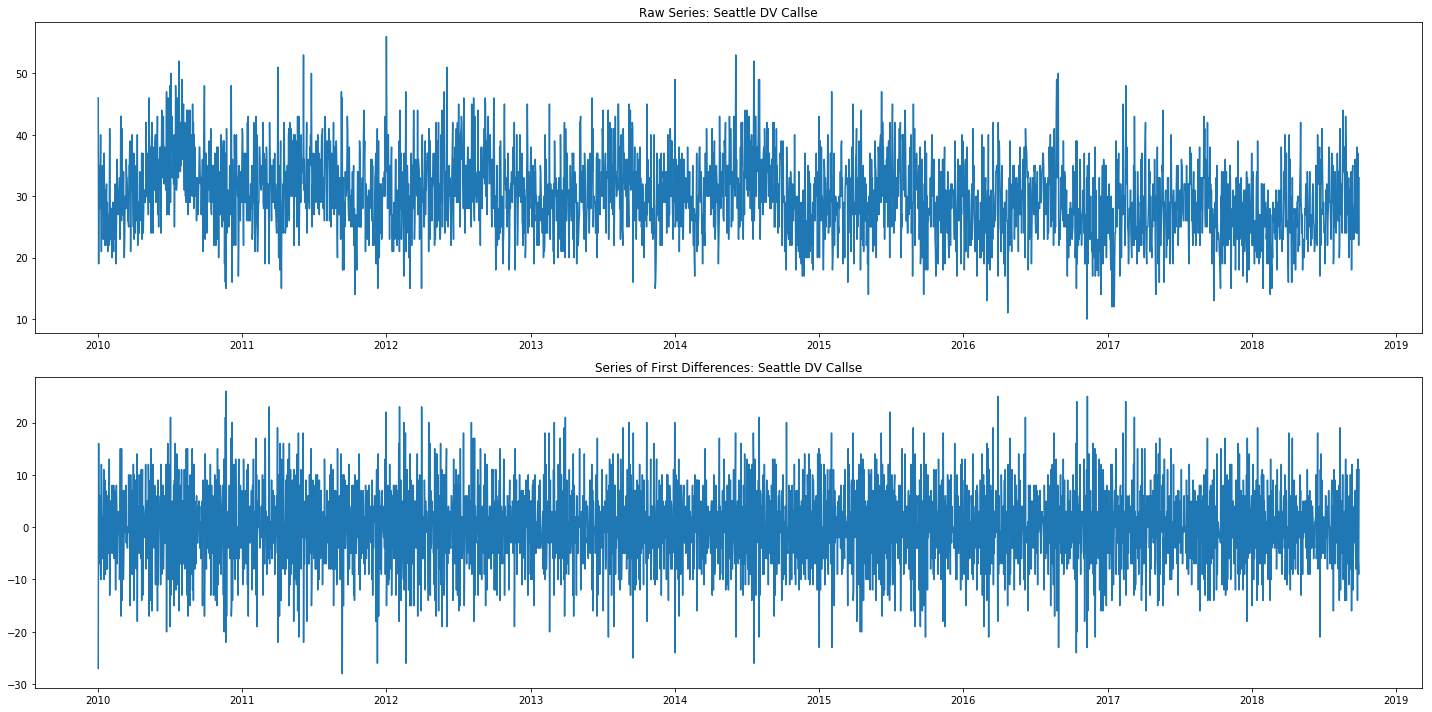

In [485]:
fig, axs = plt.subplots(2, figsize=(20, 10))
plot_series_and_difference(axs, call_counts, 'Seattle DV Callse')
fig.tight_layout()

/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3175: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)


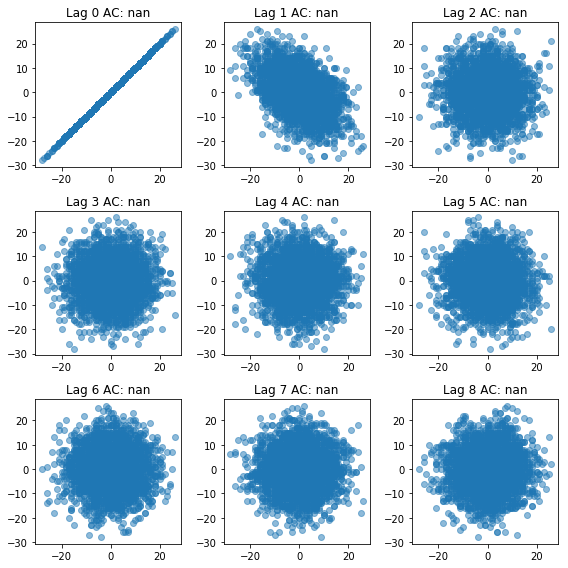

In [489]:
calls_diff = call_counts.diff()[1:]

fig, axs = plt.subplots(3, 3, figsize=(8, 8))

for i, ax in enumerate(axs.flatten()):
    series, lagged = series_and_lagged(calls_diff, lag=i)
    autocorr = compute_autocorrelation(calls_diff, lag=i)
    ax.scatter(series, lagged, alpha=0.5)
    ax.set_title("Lag {0} AC: {1:2.2f}".format(i, autocorr))
    
plt.tight_layout()

In [487]:
autocorr

nan

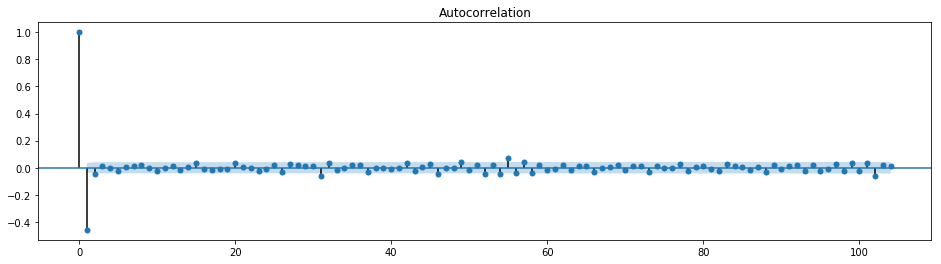

In [494]:
fig, ax = plt.subplots(1, figsize=(16, 4))

_ = sm.graphics.tsa.plot_acf(calls_diff, lags=2*52, ax=ax)

In [ ]:
#96208

In [497]:
calls_full_df.columns

Index(['index', 'BEAT', 'CALL_CODE', 'CALL_DESC', 'CALL GROUP', 'YEAR',
       'MAP COLOR', 'CALL VOLUME', 'Current Year Mark', 'Select View',
       'Boundary Selection', 'CALL DESCRIPTION', 'CALL CODE', 'Map Selection',
       'DAY_ONLY', 'EVENT', 'Geometry (MCPP MAP.shp)', 'Geometry',
       'Geometry (BEAT MAP.shp)', 'HOW_RECVD', 'NEIGHBORHOOD',
       'Number of Records', 'ORIG_TIME_QUEUED', 'PCT', 'PCT Full', 'PRECINCT',
       'Beat', 'first prec (BEAT MAP.shp)', 'Neighborho',
       'precinct (MCPP MAP.shp)', 'Precinct', 'sector (BEAT MAP.shp)',
       'st area sh (MCPP MAP.shp)', 'St Area Sh', 'st area sh (BEAT MAP.shp)',
       'st length  (MCPP MAP.shp)', 'St Length', 'st length  (BEAT MAP.shp)',
       'dt_time', 'date', 'year', 'month', 'day', 'day_of_week', 'month_day',
       'islamic_holiday', 'jewish_holiday', 'full_moon', 'new_moon',
       'temp_min', 'temp_max', 'precip', 'snow', 'precip^2', 'snow^2',
       'local_event', 'type', 'seahawks_game', 'huskies_game', 's

In [537]:
calls_df = (calls_full_df[['date', 'NEIGHBORHOOD', 'year', 'month', 'day', 'day_of_week', 'month_day', 
                           'islamic_holiday', 'jewish_holiday', 'full_moon', 'new_moon',
                           'temp_min', 'temp_max', 'precip', 'snow', 'precip^2', 'snow^2',
                           'local_event', 'seahawks_game', 'huskies_game', 'sounders_game','holiday', 'EVENT']]
           .rename(columns={'NEIGHBORHOOD':'neighborhood', 'EVENT':'event'}))

In [501]:
counts_w_features = 

96208

In [512]:
calls_df.groupby(by=['date', 'year', 'month', 'day', 'day_of_week', 'month_day','islamic_holiday', 'jewish_holiday', 'full_moon', 'new_moon', 'temp_min', 'temp_max', 'precip', 'snow', 'precip^2', 'snow^2','local_event', 'seahawks_game', 'huskies_game', 'sounders_game','holiday']).count()

,,,,,,,,,,,,,,,,,,,,,neighborhood,event
date,year,month,day,day_of_week,month_day,islamic_holiday,jewish_holiday,full_moon,new_moon,temp_min,temp_max,precip,snow,precip^2,snow^2,local_event,seahawks_game,huskies_game,sounders_game,holiday,,


In [554]:
temp = calls_df[['date', 'year', 'month', 'day', 'day_of_week','month_day',
                 'full_moon', 'new_moon','temp_min', 'temp_max','precip',
                 'snow', 'precip^2', 'snow^2','event']]


In [555]:
count_w_features = temp.groupby(['date', 'year', 'month', 'day', 'day_of_week',
                                'month_day', 'full_moon', 'new_moon', 'temp_min',
                                'temp_max','precip', 'snow', 'precip^2',
                                 'snow^2']).count().rename(columns={'event':'num_calls'})

In [550]:
count_w_features.reset_index(inplace=True)

In [556]:
count_w_features = count_w_features.join(custom_holidays.set_index('date'), on='date')

In [557]:
count_w_features = count_w_features.join(islamic_holidays.set_index('date'), on='date')

In [558]:
count_w_features = count_w_features.join(jewish_holidays.set_index('date'), on='date')

In [559]:
count_w_features = count_w_features.join(seattle_events.set_index('date'), on='date')

In [560]:
count_w_features = count_w_features.join(seahawks_schedule[['date','seahawks_game']].set_index('date'), on='date')

In [561]:
count_w_features = count_w_features.join(huskies_schedule[['date','huskies_game']].set_index('date'), on='date')

In [562]:
count_w_features = count_w_features.join(sounders_schedule[['date','sounders_game']].set_index('date'), on='date')

In [545]:
'''
calls_full_df = calls_full_df.join(custom_holidays.set_index('date'), on='date')
calls_full_df = calls_full_df.join(islamic_holidays.set_index('date'), on='date')
calls_full_df = calls_full_df.join(jewish_holidays.set_index('date'), on='date')
calls_full_df = calls_full_df.join(seattle_events.set_index('date'), on='date')
calls_full_df = calls_full_df.join(seahawks_schedule[['date','seahawks_game']].set_index('date'), on='date')
calls_full_df = calls_full_df.join(huskies_schedule[['date','huskies_game']].set_index('date'), on='date')
calls_full_df = calls_full_df.join(sounders_schedule[['date','sounders_game']].set_index('date'), on='date')
'''

"\ncalls_full_df = calls_full_df.join(custom_holidays.set_index('date'), on='date')\ncalls_full_df = calls_full_df.join(islamic_holidays.set_index('date'), on='date')\ncalls_full_df = calls_full_df.join(jewish_holidays.set_index('date'), on='date')\ncalls_full_df = calls_full_df.join(seattle_events.set_index('date'), on='date')\ncalls_full_df = calls_full_df.join(seahawks_schedule[['date','seahawks_game']].set_index('date'), on='date')\ncalls_full_df = calls_full_df.join(huskies_schedule[['date','huskies_game']].set_index('date'), on='date')\ncalls_full_df = calls_full_df.join(sounders_schedule[['date','sounders_game']].set_index('date'), on='date')\n"

In [563]:
count_w_features

,,,,,,,,,,,,,,num_calls,holiday,islamic_holiday,jewish_holiday,local_event,seahawks_game,huskies_game,sounders_game
,year,month,day,day_of_week,month_day,full_moon,new_moon,temp_min,temp_max,precip,snow,precip^2,snow^2,,,,,,,,
2010-01-01,2010,1,1,4,01/01,True,False,45,52,0.40,0.0,0.1600,0.0,46,New Year's Day,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-02,2010,1,2,5,01/02,False,False,43,47,0.06,0.0,0.0036,0.0,19,NaN,NaN,NaN,NaN,home_Regular,NaN,NaN
2010-01-03,2010,1,3,6,01/03,False,False,39,48,0.03,0.0,0.0009,0.0,35,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-04,2010,1,4,0,01/04,False,False,44,49,0.98,0.0,0.9604,0.0,28,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,2010,1,5,1,01/05,False,False,44,50,0.14,0.0,0.0196,0.0,29,NaN,NaN,NaN,NaN,NaN,NaN,home
2010-01-06,2010,1,6,2,01/06,False,False,42,50,0.00,0.0,0.0000,0.0,34,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-07,2010,1,7,3,01/07,False,False,40,48,0.04,0.0,0.0016,0.0,40,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-08,2010,1,8,4,01/08,False,False,39,46,0.81,0.0,0.6561,0.0,31,NaN,NaN,NaN,NaN,home_Playoffs,NaN,NaN
2010-01-09,2010,1,9,5,01/09,False,False,43,54,0.08,0.0,0.0064,0.0,21,NaN,NaN,NaN,NaN,NaN,NaN,home


In [565]:
def plot_trend_data(ax, name, series):
    ax.plot(series.index, series)
    ax.set_title("Google Search Trend For {}".format(name))
    
def fit_linear_trend(series):
    """Fit a linear trend to a time series.  Return the fit trend as a numpy array."""
    X = make_design_matrix(np.arange(len(series)) + 1)
    linear_trend_ols = sm.OLS(series.values, X).fit()
    linear_trend = linear_trend_ols.predict(X)
    return linear_trend

def plot_linear_trend(ax, name, series):
    linear_trend = fit_linear_trend(series)
    plot_trend_data(ax, name, series)
    ax.plot(series.index, linear_trend)

In [ ]:
fig, ax = plt.subplots(1, figsize=(14, 2))
plot_linear_trend(ax, 'python', google_trends['python'])
plt.tight_layout()